In [18]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
import os

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import load_model

In [20]:
class Data:
    def __init__(self):
        self.dataframe = pd.DataFrame([])

    def read(self, file_name: str):
        self.dataframe = pd.read_csv(file_name)

    def clean_data(self):
        """Remove null values"""
        self.dataframe = self.dataframe.dropna()

    def print_head(self):
        """Print the first few rows of the dataframe"""
        print(self.dataframe.head())

    def print_description(self):
        """Print the statistical description of the dataframe"""
        print(self.dataframe.describe())

    def normalization(self):
        """Normalize the data frame, excluding the Date column"""
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        numeric_columns = self.dataframe.select_dtypes(include=['float64', 'int64']).columns
        # Create a new DataFrame to store the normalized values
        normalized_data = self.scaler.fit_transform(self.dataframe[numeric_columns])
        # Update the original DataFrame with normalized values
        self.dataframe[numeric_columns] = normalized_data

    def visualize_open(self):
        """Plot graph for open stock values v/s date"""
        if 'Date' in self.dataframe.columns and 'Open' in self.dataframe.columns:
            self.dataframe['Date'] = pd.to_datetime(self.dataframe['Date'])
            plt.figure(figsize=(14, 7))
            plt.plot(self.dataframe['Date'], self.dataframe['Open'], label='Open Stock Prices')
            plt.title('Open Stock Prices Over Time')
            plt.xlabel('Date')
            plt.ylabel('Open Stock Price')
            plt.legend()
            plt.show()
        else:
            print("Date and/or Open column not found in the dataframe")

    def visualize_close(self):
        """Plot graph for close stock values v/s date"""
        if 'Date' in self.dataframe.columns and 'Close' in self.dataframe.columns:
            self.dataframe['Date'] = pd.to_datetime(self.dataframe['Date'])
            plt.figure(figsize=(14, 7))
            plt.plot(self.dataframe['Date'], self.dataframe['Close'], label='Close Stock Prices')
            plt.title('Close Stock Prices Over Time')
            plt.xlabel('Date')
            plt.ylabel('Close Stock Price')
            plt.legend()
            plt.show()
        else:
            print("Date and/or Close column not found in the dataframe")

In [21]:
data = Data()

In [22]:
data.read('/content/TSLA (1).csv')

In [23]:
data.clean_data()

In [24]:
data.print_head()
data.print_description()

         Date       Open       High        Low      Close  Adj Close    Volume
0  2014-06-09  13.863333  13.999333  13.613333  13.687333  13.687333  42085500
1  2014-06-10  13.628667  13.798000  13.436667  13.486667  13.486667  52720500
2  2014-06-11  13.433333  13.666667  13.283333  13.631333  13.631333  59662500
3  2014-06-12  13.673333  13.992000  13.514000  13.568000  13.568000  89905500
4  2014-06-13  13.652000  13.786000  13.438667  13.761333  13.761333  53164500
              Open         High          Low        Close    Adj Close  \
count  2517.000000  2517.000000  2517.000000  2517.000000  2517.000000   
mean    101.502708   103.708412    99.129231   101.469913   101.469913   
std     108.780487   111.183327   106.122924   108.679756   108.679756   
min       9.488000    10.331333     9.403333     9.578000     9.578000   
25%      16.482668    16.706667    16.275333    16.495333    16.495333   
50%      23.009333    23.332666    22.610001    23.006001    23.006001   
75%     

In [25]:
data.normalization()

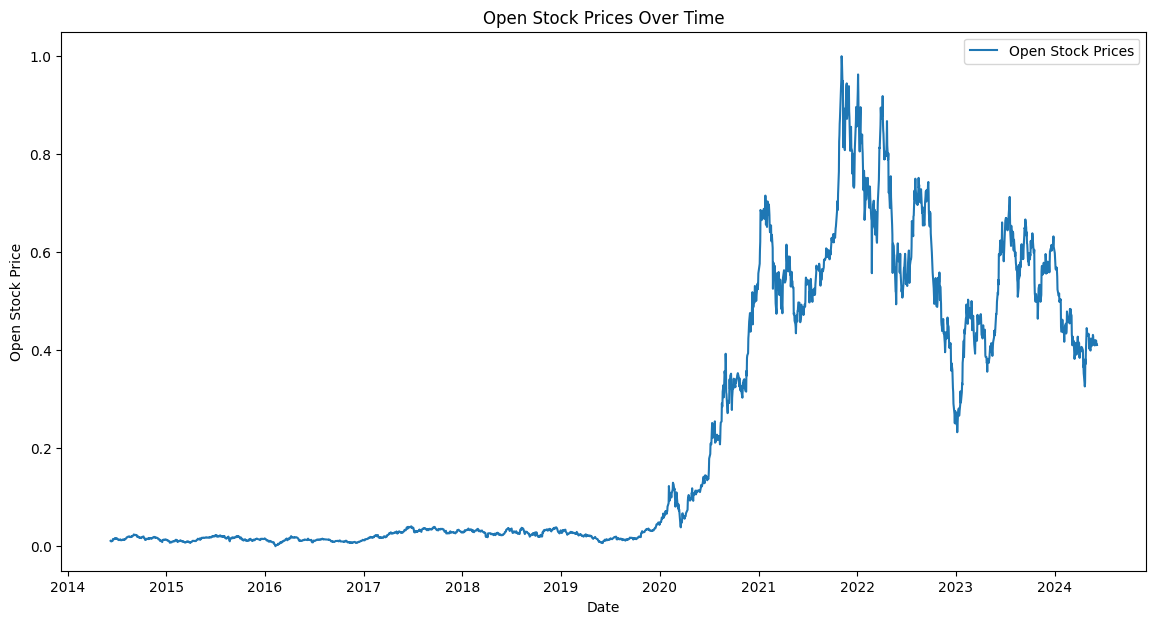

In [26]:
data.visualize_open()

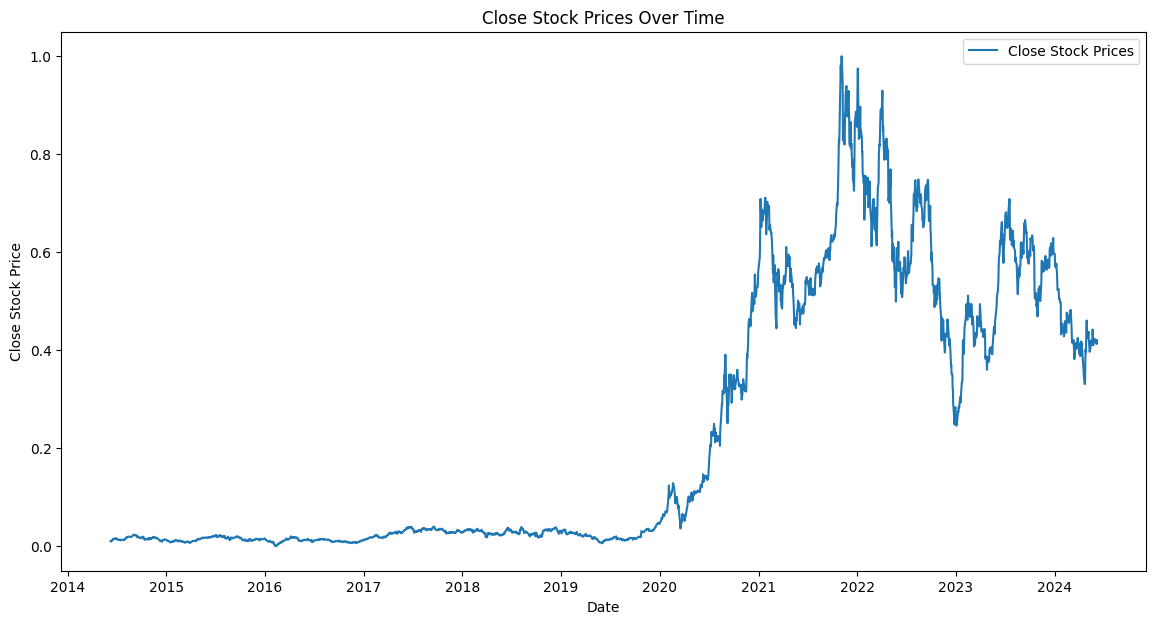

In [27]:
data.visualize_close()

In [28]:
class LSTMTrainer:
    def __init__(self, dataframe, scaler):
        self.dataframe = dataframe
        self.scaler = scaler

    def prepare_data_for_lstm(self, feature_col='Close', look_back=60):
        """Prepare data for LSTM by creating sequences"""
        data = self.dataframe[feature_col].values
        data = data.reshape(-1, 1)  # Reshape to (n_samples, 1)
        X, y = [], []
        for i in range(len(data) - look_back):
            X.append(data[i:i + look_back])
            y.append(data[i + look_back])
        X, y = np.array(X), np.array(y)
        # Split data while preserving the number of features
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
        return X_train, X_test, y_train, y_test.reshape(-1, 1)

    def build_and_train_lstm(self, feature_col='Close', look_back=60, epochs=100, batch_size=32):
        """Build and train the LSTM model"""
        X_train, X_test, y_train, y_test = self.prepare_data_for_lstm(feature_col, look_back)

        model = Sequential()
        model.add(LSTM(units=50, return_sequences=True, input_shape=(look_back, 1)))
        model.add(LSTM(units=50))
        model.add(Dense(1))

        model.compile(optimizer='adam', loss='mean_squared_error')

        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))

        self.model = model
        self.X_test = X_test
        self.y_test = y_test


    def predict_and_plot(self):
        """Make predictions and plot the results"""
        predictions = self.model.predict(self.X_test)
        predictions = predictions.reshape(-1, 1)

        # Extract the 'Close' column from the original dataframe
        self.close_scaler = MinMaxScaler(feature_range=(0, 1))  # Create a new scaler for just the 'Close' column
        self.close_scaler.fit(self.dataframe['Close'].values.reshape(-1, 1))  # Fit the scaler to the 'Close' column

        # Inverse transform predictions using the scaler fitted on 'Close' column
        predictions = self.close_scaler.inverse_transform(predictions)
        # Inverse transform actual 'Close' values
        actual = self.close_scaler.inverse_transform(self.y_test)

        plt.figure(figsize=(14, 7))
        plt.plot(actual, label='Actual Stock Price')
        plt.plot(predictions, label='Predicted Stock Price')
        plt.title('Actual vs Predicted Stock Prices')
        plt.xlabel('Time')
        plt.ylabel('Stock Price')
        plt.legend()
        plt.show()


    def evaluate_model(self):
        """Calculates and prints evaluation metrics."""
        predictions = self.model.predict(self.X_test)
        predictions = self.close_scaler.inverse_transform(predictions)  # Assuming you're using the close_scaler
        actual = self.close_scaler.inverse_transform(self.y_test)

        mse = mean_squared_error(actual, predictions)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(actual, predictions)
        r2 = r2_score(actual, predictions)

        print(f"Mean Squared Error (MSE): {mse}")
        print(f"Root Mean Squared Error (RMSE): {rmse}")
        print(f"Mean Absolute Error (MAE): {mae}")
        print(f"R-squared (R2): {r2}")


    def save_model(self, model_path='model.h5'):
        """Save the trained model to a file"""
        self.model.save(model_path)
        print(f"Model saved to {model_path}")

    def load_model(self, model_path='model.h5'):
        """Load a trained model from a file"""
        self.model = load_model(model_path)
        print(f"Model loaded from {model_path}")

In [29]:
trainer = LSTMTrainer(data.dataframe, data.scaler)

In [30]:
trainer.build_and_train_lstm(feature_col='Close', look_back=60, epochs=100, batch_size=32)

Epoch 1/100
62/62 [==============================] - 8s 62ms/step - loss: 0.0110 - val_loss: 0.0023
Epoch 2/100
62/62 [==============================] - 3s 49ms/step - loss: 8.7197e-04 - val_loss: 0.0026
Epoch 3/100
62/62 [==============================] - 4s 72ms/step - loss: 7.8007e-04 - val_loss: 0.0020
Epoch 4/100
62/62 [==============================] - 3s 48ms/step - loss: 7.4689e-04 - val_loss: 0.0018
Epoch 5/100
62/62 [==============================] - 3s 49ms/step - loss: 6.4636e-04 - val_loss: 0.0014
Epoch 6/100
62/62 [==============================] - 3s 49ms/step - loss: 6.6218e-04 - val_loss: 0.0017
Epoch 7/100
62/62 [==============================] - 4s 72ms/step - loss: 6.1061e-04 - val_loss: 0.0015
Epoch 8/100
62/62 [==============================] - 3s 49ms/step - loss: 5.5822e-04 - val_loss: 0.0012
Epoch 9/100
62/62 [==============================] - 3s 50ms/step - loss: 5.4357e-04 - val_loss: 0.0012
Epoch 10/100
62/62 [==============================] - 3s 49ms/step -

16/16 [==============================] - 1s 21ms/step


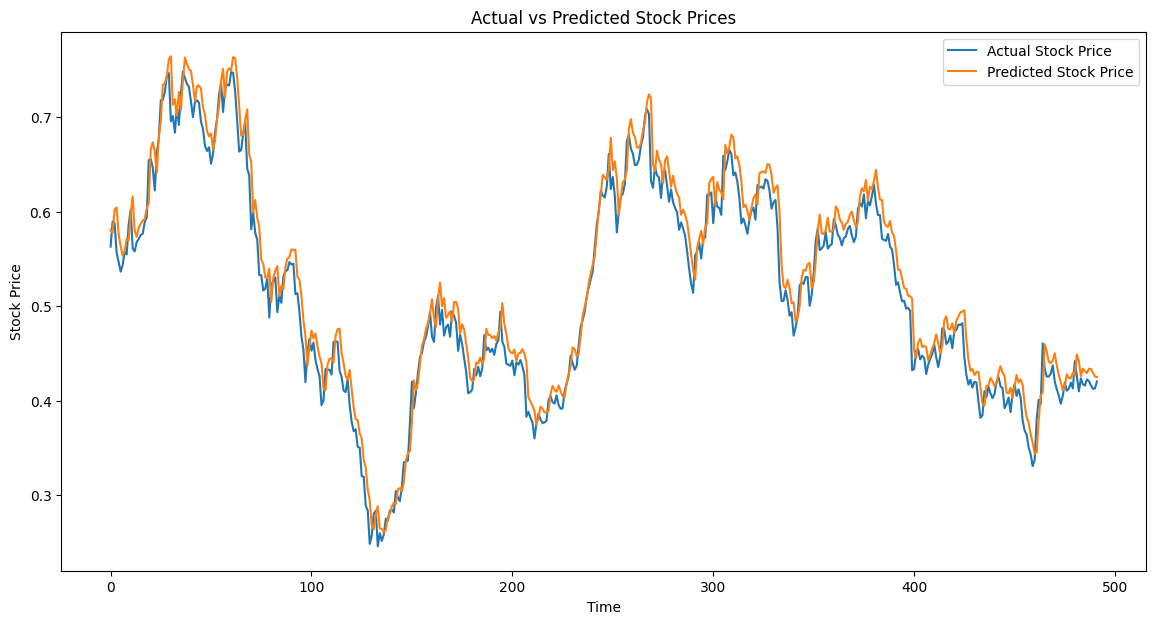

In [31]:
trainer.predict_and_plot()

In [32]:
trainer.evaluate_model()

16/16 [==============================] - 0s 14ms/step
Mean Squared Error (MSE): 0.0005387755755927127
Root Mean Squared Error (RMSE): 0.02321153970749706
Mean Absolute Error (MAE): 0.01855777079783058
R-squared (R2): 0.9576477389703906


In [33]:
trainer.save_model('models/lstm_model.h5')

Model saved to models/lstm_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [34]:
trainer.load_model('models/lstm_model.h5')

Model loaded from models/lstm_model.h5
